In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_excel("ts_data_bb_ar.xlsx")

In [3]:
df.head()

,Time,Value
0,1,0.000000
1,2,-0.090263
2,3,0.749995
3,4,1.247887
4,5,0.131282


In [4]:
df.shape

(10000, 2)

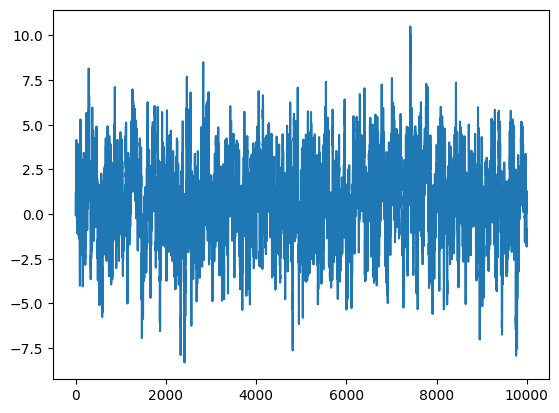

In [5]:
plt.plot(df["Value"])

In [6]:
X = df["Value"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -22.184930
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary


<center><h1>Auto Regressive Model</h1></center>

$$
Y_{t}=\alpha+\beta_{1} Y_{t-1}+\beta_{2} Y_{t-2}+\ldots+\beta_{p} Y_{t-p}+\epsilon_{1}
$$

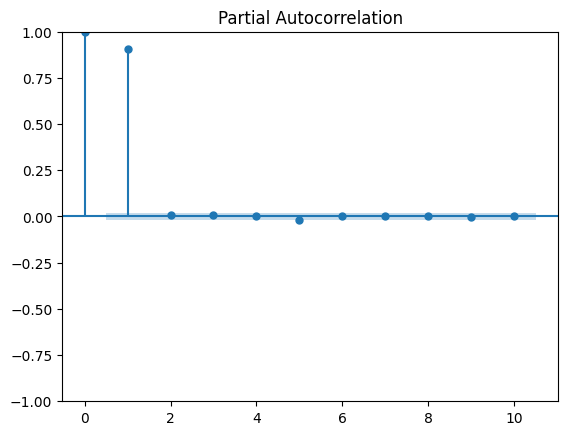

In [7]:
plot_pacf(X, lags=10);

In [8]:
df["Values_shifted"]  = df["Value"].shift()

In [9]:
df.head()

,Time,Value,Values_shifted
0,1,0.000000,NaN
1,2,-0.090263,0.000000
2,3,0.749995,-0.090263
3,4,1.247887,0.749995
4,5,0.131282,1.247887


In [10]:
df.drop('Time', axis = 1, inplace=True)

In [11]:
df.dropna(inplace=True)

In [12]:
df.head()

,Value,Values_shifted
1,-0.090263,0.000000
2,0.749995,-0.090263
3,1.247887,0.749995
4,0.131282,1.247887
5,0.562619,0.131282


In [13]:
y = df.Value.values
X = df.Values_shifted.values

In [14]:
train_size = int(len(X) * 0.80)

In [15]:
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [16]:
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [18]:
y_pred = rf.predict(X_test)

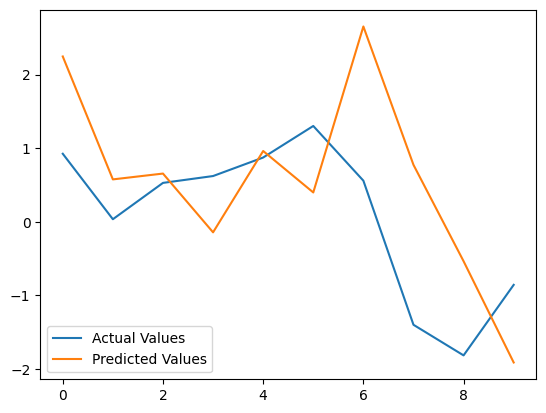

In [19]:
plt.plot(y_test[-10:], label="Actual Values")
plt.plot(y_pred[-10:], label="Predicted Values")
plt.legend()
plt.show()

In [22]:
print("MSE random forest: ", mean_squared_error(y_pred, y_test))
print("r2 random forest: ", r2_score(y_pred, y_test))

MSE random forest:  1.371993167782988
r2 random forest:  0.7157230348840207


In [17]:
from xgboost import XGBRFRegressor
xgb = XGBRFRegressor()
xgb.fit(X_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

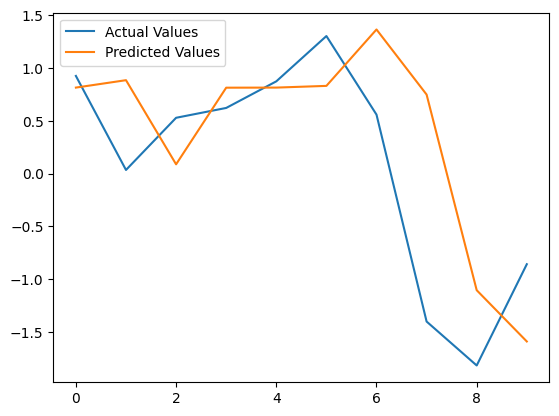

In [18]:
y_pred_xgb = xgb.predict(X_test)

plt.plot(y_test[-10:], label="Actual Values")
plt.plot(y_pred_xgb[-10:], label="Predicted Values")
plt.legend()
plt.show()

In [19]:
print("MSE random forest: ", mean_squared_error(y_pred_xgb, y_test))
print("r2 random forest: ", r2_score(y_pred_xgb, y_test))

MSE random forest:  0.9370233804710018
r2 random forest:  0.7859745134594552


* Using a basic auto-regressive degree-1 model

In [25]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y_train, order=(1,0,0))

In [26]:
model_fit = model.fit()

In [27]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7999
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -11364.832
Date:                Sun, 08 Oct 2023   AIC                          22735.664
Time:                        17:58:52   BIC                          22756.625
Sample:                             0   HQIC                         22742.838
                               - 7999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7245      0.119      6.113      0.000       0.492       0.957
ar.L1          0.9055      0.005    189.833      0.000       0.896       0.915
sigma2         1.0035      0.016     62.497      0.0